In [ ]:
#!pip install Pydub
#!pip install PyWavelets


import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pywt
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import audioread
from pydub import AudioSegment
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the datasets
#file_30_sec = 'data/GTZAN/features_30_sec.csv'
#file_3_sec = 'data/GTZAN/features_3_sec.csv'

file_30_sec = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/features_30_sec.csv'
file_3_sec = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/features_3_sec.csv'
audio_directory = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/genres_original'

df_30_sec = pd.read_csv(file_30_sec)
df_3_sec = pd.read_csv(file_3_sec)

In [ ]:
# Function to extract spectrograms and wavelet features
def extract_features(file_path, sr=22050, n_mels=128, wavelet='db1'):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr)
        # Extract Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_flattened = mel_spectrogram_db.flatten()  # Flatten for use in ML models

        # Extract wavelet features
        coeffs = pywt.wavedec(y, wavelet, level=5)
        wavelet_features = np.concatenate([np.array(c).flatten() for c in coeffs])

        # Extract chroma features
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_features_flattened = chroma_stft.flatten()  # Flatten for use in ML models

        # Combine all features into a single feature vector
        combined_features = np.concatenate((mel_spectrogram_flattened, wavelet_features, chroma_features_flattened), axis=0)
    except (FileNotFoundError, librosa.util.exceptions.LibrosaError, audioread.NoBackendError):
        # If audio file is not found or cannot be loaded, use features from CSV instead
        print(f"Audio file {file_path} not found or cannot be processed. Using CSV features instead.")
        combined_features = None

    return combined_features

# Splitting the dataset into training, validation, and test sets
def split_data(df, test_size=0.2, val_size=0.2):
    train_val, test = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=val_size, stratify=train_val['label'], random_state=42)
    return train, val, test

# Function to process the entire dataset and extract features
def process_dataset(df, audio_directory):
    features = []
    labels = []
    for idx, row in df.iterrows():
        file_path = os.path.join(audio_directory, row['label'], row['filename'])
        feature_vector = extract_features(file_path)
        # If audio features cannot be extracted, use CSV features
        if feature_vector is None:
            feature_vector = row.drop(['label']).filter(regex='^(?!filename)').values.astype(np.float32)
        features.append(feature_vector)
        labels.append(row['label'])
    # Ensure all feature vectors have the same length by padding or truncating
    max_length = max(len(f) for f in features)
    features = np.array([np.pad(f, (0, max_length - len(f)), 'constant') if len(f) < max_length else f[:max_length] for f in features])
    return features, np.array(labels)

In [ ]:
# Standardizing dataset before splitting
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_30_sec_numeric = df_30_sec.select_dtypes(include=['float64', 'int64']).copy()
df_30_sec[df_30_sec_numeric.columns] = scaler.fit_transform(df_30_sec_numeric)

df_3_sec_numeric = df_3_sec.select_dtypes(include=['float64', 'int64']).copy()
df_3_sec[df_3_sec_numeric.columns] = scaler.fit_transform(df_3_sec_numeric)

In [ ]:
# Splitting the dataset for 30-sec
train_df_30s, val_df_30s, test_df_30s = split_data(df_30_sec)

# Extract and process features for 30-sec dataset
#audio_directory = 'data/GTZAN/genres_original'

# Extract and process features for 30-sec dataset
#audio_directory = 'data/GTZAN/genres_original'

# Combined Features for 30-sec
train_features_30s, train_labels_30s = process_dataset(train_df_30s, audio_directory)
val_features_30s, val_labels_30s = process_dataset(val_df_30s, audio_directory)
test_features_30s, test_labels_30s = process_dataset(test_df_30s, audio_directory)

<ipython-input-11-1192b0c4e0fd>:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio file /content/drive/MyDrive/DS4420_Project/data/GTZAN/genres_original/jazz/jazz.00054.wav not found or cannot be processed. Using CSV features instead.


In [ ]:
# Splitting the dataset for 3-sec
train_df_3s, val_df_3s, test_df_3s = split_data(df_3_sec)

# Combined Features for 3-sec
train_features_3s, train_labels_3s = process_dataset(train_df_3s, audio_directory)
val_features_3s, val_labels_3s = process_dataset(val_df_3s, audio_directory)
test_features_3s, test_labels_3s = process_dataset(test_df_3s, audio_directory)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# CNN Model Implementation
# Function to build a CNN model

def build_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(256, activation='relu'))  # Increased number of units
    model.add(layers.Reshape((32, 8, 1)))  # Adjusted reshape to match input dimensions
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))  # Increased filters
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))  # Added more layers
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))  # Added deeper layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))  # Increased number of units
    model.add(layers.Dropout(0.5))  # Added Dropout layer to prevent overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Convert labels to numeric format
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_30s = le.fit_transform(train_labels_30s)
val_labels_30s = le.transform(val_labels_30s)
test_labels_30s = le.transform(test_labels_30s)

train_labels_3s = le.fit_transform(train_labels_3s)
val_labels_3s = le.transform(val_labels_3s)
test_labels_3s = le.transform(test_labels_3s)

# Callback for reducing learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# Combined Features CNN Model for 30-sec Features
combined_cnn_model_30s = build_cnn_model(train_features_30s.shape[1], len(np.unique(train_labels_30s)))
history_30s = combined_cnn_model_30s.fit(train_features_30s, train_labels_30s, epochs=100, validation_data=(val_features_30s, val_labels_30s), batch_size=32, callbacks=[reduce_lr])
combined_predictions_30s = combined_cnn_model_30s.predict(test_features_30s)
print("Combined Features Predictions for 30-sec Features: ", np.argmax(combined_predictions_30s, axis=1))


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.1070 - loss: 102.7688 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1146 - loss: 2.3038 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1160 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 4/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0869 - loss: 2.3027
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0881 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1107 - loss: 2.3023 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0982 - loss: 2.302

In [ ]:
# Combined Features CNN Model for 3-sec Features
combined_cnn_model_3s = build_cnn_model(train_features_3s.shape[1], len(np.unique(train_labels_3s)))
history_3s = combined_cnn_model_3s.fit(train_features_3s, train_labels_3s, epochs=100, validation_data=(val_features_3s, val_labels_3s), batch_size=32, callbacks=[reduce_lr])
combined_predictions_3s = combined_cnn_model_3s.predict(test_features_3s)
print("Combined Features Predictions for 3-sec Features: ", np.argmax(combined_predictions_3s, axis=1))

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2106 - loss: 2.0812 - val_accuracy: 0.5704 - val_loss: 1.2039 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5656 - loss: 1.2331 - val_accuracy: 0.7211 - val_loss: 0.8261 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7132 - loss: 0.8683 - val_accuracy: 0.7598 - val_loss: 0.6976 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7873 - loss: 0.6598 - val_accuracy: 0.7930 - val_loss: 0.6300 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8462 - loss: 0.4909 - val_accuracy: 0.8149 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8660 - loss: 0.4208 - val_accuracy: 0.8343 - val_loss: 0.5638 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8985 - loss: 0

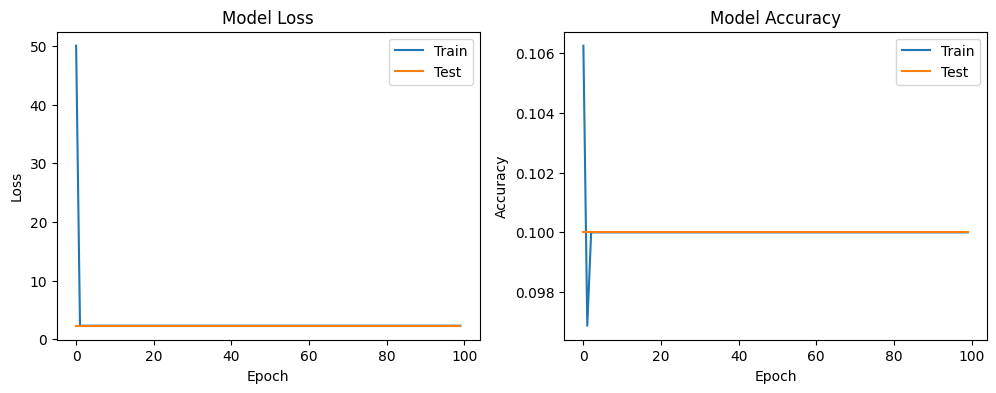

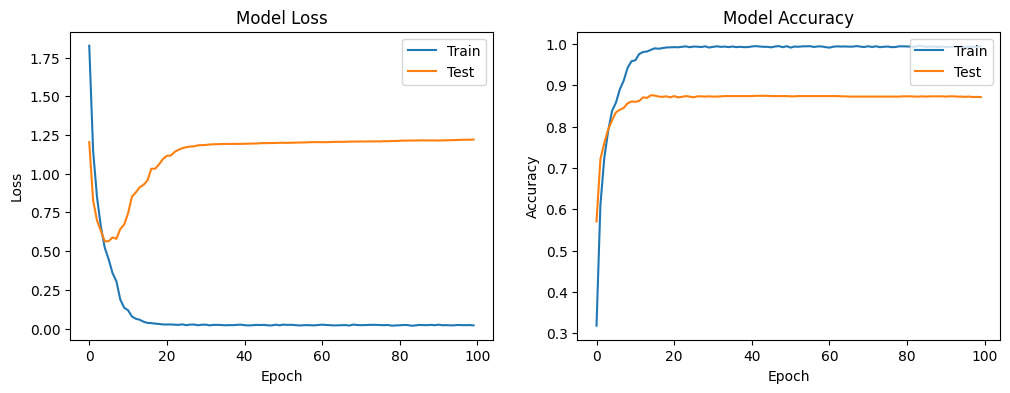

In [ ]:
# Plotting model loss and accuracy for 30-sec and 3-sec
import matplotlib.pyplot as plt

def plot_losses(hist):

  fig, axs = plt.subplots(1,2, figsize=(12, 4))
  axs[0].plot(hist.history['loss'])
  axs[0].plot(hist.history['val_loss'])
  axs[0].set_title('Model Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Test'], loc='upper right')

  axs[1].plot(hist.history['accuracy'])
  axs[1].plot(hist.history['val_accuracy'])
  axs[1].set_title('Model Accuracy')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Test'], loc='upper right')
  plt.show()

# Plot for 30-sec model
plot_losses(history_30s)

# Plot for 3-sec model
plot_losses(history_3s)